<a id="top"></a>
# Starbucks Capstone Challenge

## Overview

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

The task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

Transactional data shows user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. It also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

#### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

#### Tips

Take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. Therefore, try to assess what a certain demographic group will buy when not receiving any offers.

## Objectives

In this notebook, I will develop heurisitics to determine which offer should be sent and how spends vary across customers with demographics.

Based on the findings, two machine learning models will be built:
- a classification model to predict whether or not a customer will respond to an offer
- a regression model to predict spends of customers based on demographics and offer type

## Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

## Load packages

In [1]:
# data analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import math

# utils
import os
import json
import pickle
from tqdm import tqdm 
import datetime

%matplotlib inline

In [2]:
# Check if xgboost package exists
# or install it 
try:
    import xgboost
except ImportError as e:
    !pip install xgboost

In [3]:
# modeling 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [4]:
# Oversampling & undersampling
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from collections import Counter
print(imblearn.__version__)

0.9.0


# Table of contents

This project is divided into two Jupyter Notebooks.

- wrangling.ipynb
- analysis.ipynb

This notebook (`analysis.ipynb`) starts continues the data wrangling works that can be found in `wrangling.ipynb`.

3. Explore data: Part1 [link](#explore-part1) <- to skip data cleaning
4. Explore data: Part2 [link](#explore-part2)
5. Feature engineering [link](#feature)
6. Modeling [link](#model)
7. Build the final model [link](#final)
8. Conclusion [link](#conclude)

---
<a id="explore-part1"></a>
## SECTION 3 Explore data : Part 1

Here we explore the individual dataset first. In the next section (Part2) we will continue the analysis with the merged dataset. 

In [117]:
# Load the clean dataset
portfolio = pd.read_csv('data/portfolio_clean.csv')
profile = pd.read_csv('data/profile_clean.csv')
transcript = pd.read_csv('data/transcript_clean.csv')
transaction = pd.read_csv('data/transactions_pivoted.csv')

In [118]:
portfolio.head()

,reward,difficulty,duration,offer_type,id,web,email,social,mobile
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0


### 3a. Offer types and channels

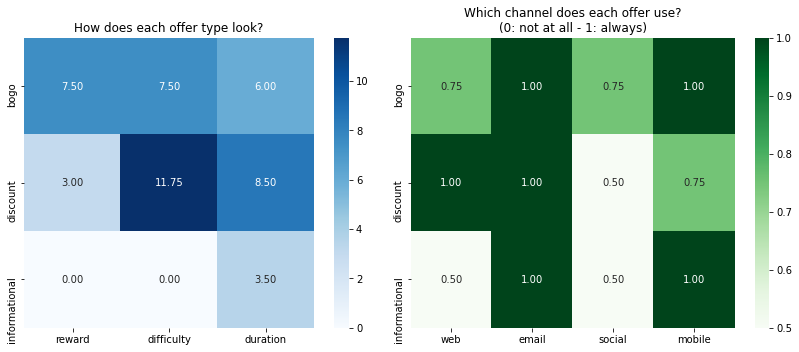

In [119]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))

sns.heatmap(portfolio.iloc[:, :4].groupby('offer_type').mean(), 
            annot=True, fmt='.2f', square=True, cmap='Blues', ax=ax1);
sns.heatmap(portfolio.iloc[:, 3:].groupby('offer_type').mean(), 
            annot=True, fmt='.2f', cmap='Greens', ax=ax2);

ax1.set(title ='How does each offer type look?', xlabel='', ylabel='');
ax2.set(title ='Which channel does each offer use?\n(0: not at all - 1: always)',
        xlabel='', ylabel='')

plt.tight_layout()

# Save figure
plt.show()

#### Offers
- **discount** offer requires the highest spends to redeem (the most difficult) with the longest duration - longest engagment with customers. 
- **bogo** offer gives the most rewards with comparatively lower spends requred - as the name (Buy One Get One For Free) suggests.
- **informational** offer does not require reward and spends.


#### Channels
Regardless of offer type, **email** is always used when communicating the offer. **bogo** uses all four channels more intensively. The analysis will be more meaningful when offer type is explored together with customer profile and transction data, which will be done later after mering the dataset.

## 3b.  Demographics

In [120]:
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'])
profile.head()

,gender,age,id,became_member_on,income
0,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
1,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
2,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0
3,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0
4,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0


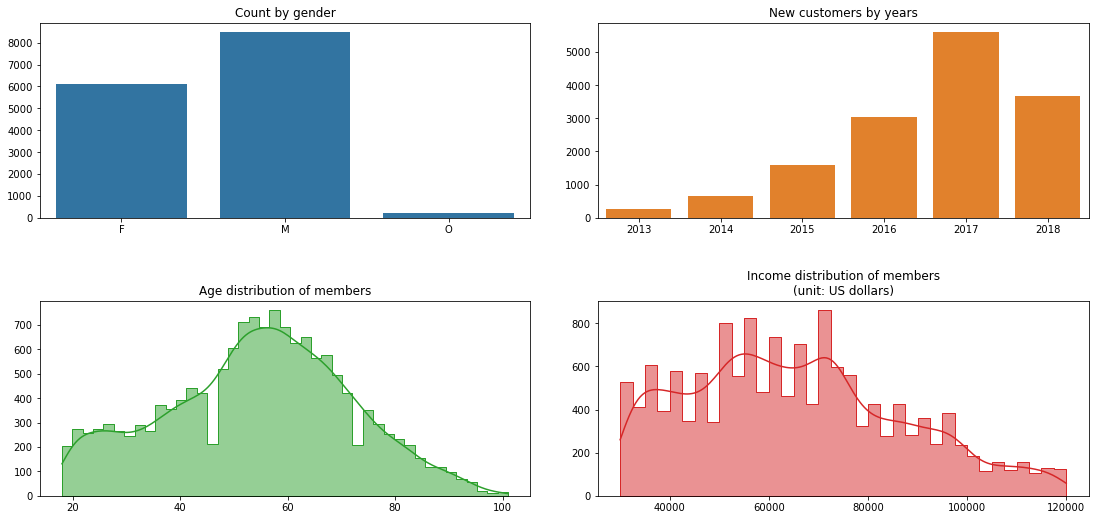

In [121]:
base_colors = sns.color_palette()[:4]

fig, axes = plt.subplots(2, 2, figsize=(16,8))

fig1 = sns.countplot(x=profile.gender, color=base_colors[0], ax=axes[0,0])
fig2 = sns.countplot(x=profile.became_member_on.dt.year, color=base_colors[1], ax=axes[0,1])
fig3 = sns.histplot(x=profile.age, color=base_colors[2], kde=True, element='step', ax=axes[1,0])
fig4 = sns.histplot(x=profile.income, color=base_colors[3], kde=True, element='step', ax=axes[1,1])

fig1.set(title='Count by gender', xlabel='', ylabel='')
fig2.set(title='New customers by years', xlabel='', ylabel='')
fig3.set(title='Age distribution of members', xlabel='', ylabel='')
fig4.set(title='Income distribution of members\n(unit: US dollars)', xlabel='', ylabel='')

plt.tight_layout(pad=3.5)
plt.show()

**Gender:** slightly more male respondants (57%) than female while others exist. 

**New customers:** The growth of new customer base is increasing assuming other factors, such as total annual visitor volume, are consistent. 

**Age:** The minimum age is 18 which may be due to age restriction for members. With the median of 55, 50% of the members fall into between 42 and 66. Although trivial, some members are above 100, which may be correct but likely caused by survey error.

**Income:** Median income is $64,000. The distribution is skewed to the right which seems natural for income distribution.

## 3c. Offer completion
Using the cleaned, pivoted dataframe saved in `transaction_pivoted.csv`

In [122]:
print('Number of unique customers: ', transaction.person.nunique())
print('Number of unique offer types: ', transaction.offer_id.nunique())

Number of unique customers:  17000
Number of unique offer types:  10


The number of total record is 169940, which I interpret as the total mix of possible transactions. 

In [123]:
# Map label number to name

label_num_to_name = {1: 'complete', 2: 'inactive', 3: 'active', 4: 'indifferent', 5: 'not received'}
transaction['label_descr'] = transaction['label'].map(label_num_to_name)

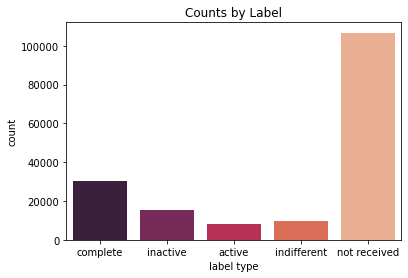

In [124]:
# Set color for the plots

label_order = label_num_to_name.values()
fig = sns.countplot(x=transaction.label_descr, palette="rocket", order=label_order);
fig.set(title='Counts by Label', xlabel='label type', ylabel='count');
plt.xticks()
plt.show()

In [125]:
# Proportions of each label

transaction['label_descr'].value_counts() / transaction.shape[0]

not received    0.627718
complete        0.176829
inactive        0.090388
indifferent     0.056571
active          0.048494
Name: label_descr, dtype: float64

17000 unique customers and 10 unique offers are represented in this dataset, which gives 170,000 mix of offers . Around 63% offers are `unsent` (label 5), most likely because
- offers were not relevant for customers
- opportunities were misinterpreted and missed

In [126]:
count_total_sent = transaction.loc[transaction.label != 5, 'label'].shape[0]
transaction.loc[transaction.label != 5, 'label_descr'].value_counts() / count_total_sent

complete       0.474987
inactive       0.242795
indifferent    0.151956
active         0.130262
Name: label_descr, dtype: float64

Among those offers that were sent, over 47% led to the completion. In other words, either offer led to purchase or offer is information and viewed. Additionally,

- 24% of customers viewed offers but not redeemed
- 15%  were not responsive to the offer
- 13% (purchased without viewing

# informational offers: 34000
# transactional offers: 136000


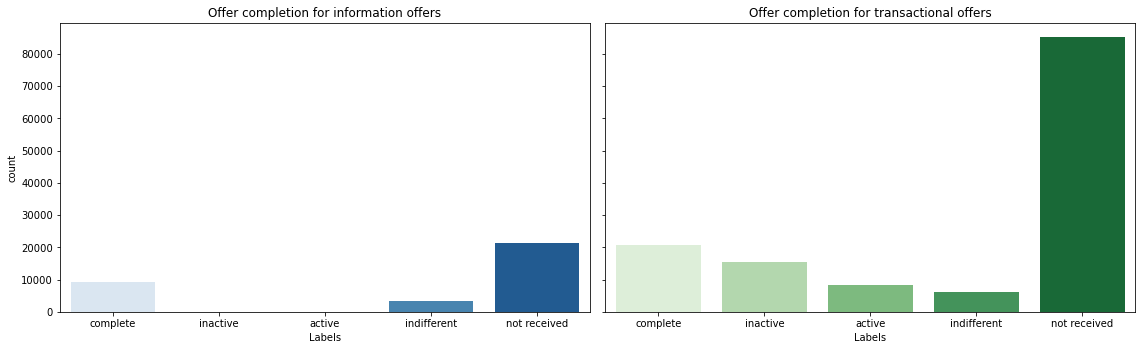

In [127]:
# Get subset data for informational and transactional offers

info_offer_ids = portfolio.loc[portfolio['offer_type'] == 'informational', 'id'].to_list()

offer_informational = transaction[transaction['offer_id'].isin(info_offer_ids)]
offer_transactional = transaction[~transaction['offer_id'].isin(info_offer_ids)]

print('# informational offers:', len(offer_informational))
print('# transactional offers:', len(offer_transactional))

# Visualization
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,5), sharey=True)

# Set order for plots

label_order = label_num_to_name.values()
fig1 = sns.countplot(x=offer_informational.label_descr, ax=ax1, palette="Blues", order=label_order);
fig2 = sns.countplot(x=offer_transactional.label_descr, ax=ax2, palette="Greens", order=label_order);

ax1.set(title='Offer completion for information offers', xlabel='Labels');
ax2.set(title='Offer completion for transactional offers', xlabel='Labels', ylabel='');

plt.tight_layout(pad=1.2)

# Save figure
plt.show()

In [128]:
offer_informational['label'].value_counts() / 34000

5.0    0.627912
1.0    0.273794
4.0    0.098294
Name: label, dtype: float64

In [129]:
offer_transactional['label'].value_counts() / 136000

5.0    0.627669
1.0    0.152588
2.0    0.112985
3.0    0.060618
4.0    0.046140
Name: label, dtype: float64

Around 20% of the total dataset are informational and the rest 80% are transactional. 
- informational offers have higher completion rate
- unsent offers were proportionally similar between informational and transactional offers, but still dominant in counts
- no inactive, active customers for informational offers (with no purchase)

<a id="explore-part2"></a>
## SECTION 4 Explore data - Part2

In this section, we would like to go deeper into offer completion by offer type and demographics. <br>
Completion can be measured for transactions that were actually sent. 

### 4a. Completion by offer type

In [130]:
transaction.head(3)

,person,offer_id,offer received,offer viewed,transaction,offer completed,label,amount,reward,label_descr
0,0009655768c64bdeb2e877511632db8f,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN,NaN,5.0,NaN,NaN,not received
1,0009655768c64bdeb2e877511632db8f,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,NaN,NaN,NaN,5.0,NaN,NaN,not received
2,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,576.0,NaN,NaN,576.0,3.0,10.27,2.0,active


In [131]:
# Subset transactions with offers sent
transactions_sent = transaction[transaction['label'] != 5].copy()

# Create a dataframe that shows
# number of completed and incomplete offers by offer id
completion_by_offer = transactions_sent.groupby(['offer_id', 'label_descr']).size().unstack()

# Compute completion rate
completion_by_offer['completion_rate'] = completion_by_offer['complete'] / completion_by_offer.sum(axis=1)

# Sort by completed rate
completion_by_offer.sort_values('completion_rate', ascending=False, inplace=True)

# Merge the data sets
completion_by_offer = pd.merge(completion_by_offer.reset_index(), portfolio, left_on='offer_id', right_on='id', how='left')

# Drop duplicated id column
completion_by_offer.drop(columns='id', inplace=True)

In [132]:
# show the prepared dataset

completion_by_offer

,offer_id,active,complete,inactive,indifferent,completion_rate,reward,difficulty,duration,offer_type,web,email,social,mobile
0,5a8bc65990b245e5a138643cd4eb9837,NaN,5674.0,NaN,646.0,0.897785,0,0,3,informational,0,1,1,1
1,fafdcd668e3743c1bb461111dcafc2a4,497.0,4033.0,1717.0,85.0,0.636924,2,10,10,discount,1,1,1,1
2,2298d6c36e964ae4a3e7e9706d1fb8c2,601.0,3820.0,1809.0,95.0,0.603953,3,7,7,discount,1,1,1,1
3,3f207df678b143eea3cee63160fa8bed,NaN,3635.0,NaN,2696.0,0.574159,0,0,4,informational,1,1,0,1
4,f19421c1d4aa40978ebb69ca19b0e20d,612.0,3129.0,2405.0,116.0,0.499681,5,5,5,bogo,1,1,1,1
5,4d5c57ea9a6940dd891ad53e9dbe8da0,449.0,2436.0,3307.0,138.0,0.384834,10,10,5,bogo,1,1,1,1
6,ae264e3637204a6fb9bb56bc8210ddfd,863.0,2314.0,2853.0,344.0,0.363037,10,10,7,bogo,0,1,1,1
7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1862.0,1922.0,1154.0,1417.0,0.302439,5,5,7,bogo,1,1,0,1
8,2906b810c7d4411798c6938adc9daaa5,1589.0,1891.0,1193.0,1612.0,0.300875,2,10,7,discount,1,1,0,1
9,0b1e1539f2cc45b7b9fa7c272da2e1d7,1771.0,1207.0,928.0,2468.0,0.189363,5,20,10,discount,1,1,0,0


In [133]:
# Get custom offer names
# offer_type + reward + difficulty + duration

# Instantiate a list of offer names
offer_names = list()

# Subset the dataframe
offset_subset = completion_by_offer[['offer_type', 'reward', 'difficulty', 'duration']]

# Iterate by row
for idx, values in offset_subset.iterrows():

    # Instantiate name
    name = ''

    for item in values:
        # If item is string, get the first 4 letters
        if type(item) == str:
            item = item[:4]

        # If item is integer, check if the value < 10, 
        # then add '0' in front and transform it to string
        if type(item) == int and item < 10:
            item = '0' + str(item)
        else:
            item = str(item)

        # Concatenate item 
        name += item

    # Add completed name to a list of offer names
    offer_names.append(name)


# Add the custom column name
completion_by_offer['offer_name'] = offer_names

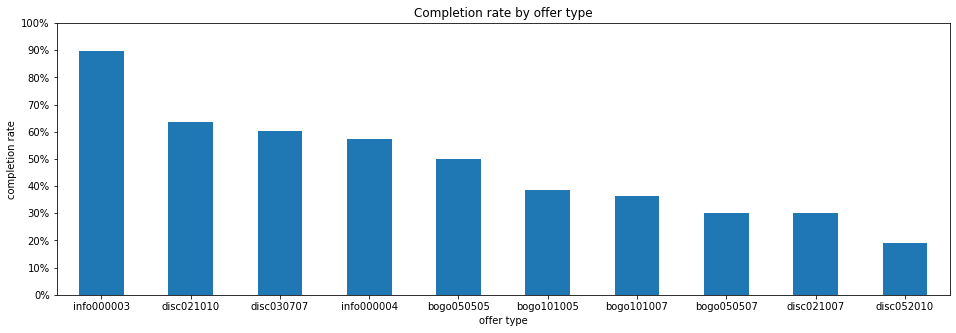

In [134]:
completion_by_offer['completion_rate'].plot(kind='bar', stacked=True, figsize=(16,5));

plt.title('Completion rate by offer type')
plt.xlabel('offer type')
plt.ylabel('completion rate')
plt.xticks(ticks=range(10), labels=offer_names, rotation=0)
plt.yticks(ticks=np.arange(0, 1+0.1, 0.1), labels=['{:.0f}%'.format(n*100) for n in np.arange(0, 1+0.1, 0.1)])
plt.show()

Informational offer with 3 day duration has nearly 90% completion. 

Amongst transtional offers (discount, bogo), disc021010 and disc030707 offers have comparatively higher completion
- disc021010 : discount offer, reward 2, difficulty 7, duration 10 
- disc030707 : discount offer, reward 3, difficulty 7, duration 7

Although **bogo** has relatively more rewards than the two discount offers, completion rate is lower.

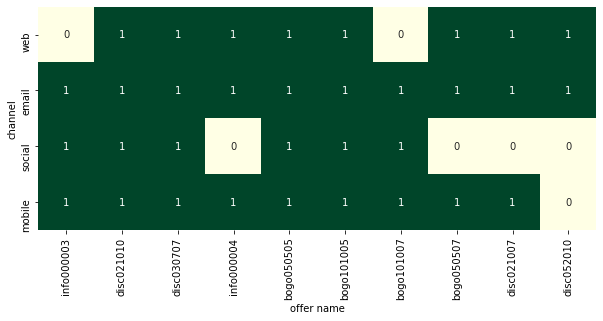

In [135]:
channels_by_offer = completion_by_offer.iloc[:, -5:].set_index('offer_name')

plt.figure(figsize=(10,6))
sns.heatmap(channels_by_offer.T, cmap='YlGn', annot=True, cbar=False, square=True)

plt.xlabel('offer name')
plt.ylabel('channel')
plt.show()

For transactional offers, higher completion rate could be associated with number of channels. Not communiting through **social** media channel is very likely to lead lower completion rate. Let's make it more granular by offer type.

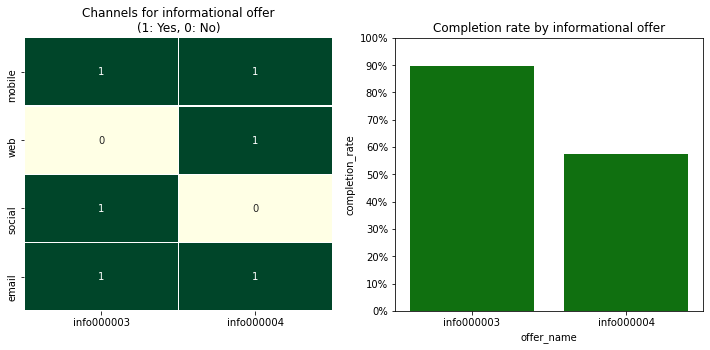

In [136]:
## Informational offers

# Subset dataset
channels = ['mobile', 'web', 'social', 'email']
completion_info = completion_by_offer.query('offer_type == "informational"')


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

# Figure1 - heatmap for binary
sns.heatmap(completion_info[channels].T, linewidths = 0.30, annot = True, 
            cmap='YlGn', cbar=False, ax=ax1);

# Labels
ax1.set_title('Channels for informational offer\n(1: Yes, 0: No)')
ax1.set(xlabel='', ylabel='')
ax1.set_xticklabels(labels=completion_info['offer_name'], rotation=0)

# Figure2 - bar
sns.barplot(x='offer_name', y='completion_rate', data=completion_info, ax=ax2, color='green')

# Labels
ax2.set(title='Completion rate by informational offer')
ax2.set_xticks(ticks=np.arange(len(completion_info)))
ax2.set_xticklabels(labels=completion_info['offer_name'], rotation=0)
ax2.set_yticks(ticks=np.arange(0, 1+0.1, 0.1))
ax2.set_yticklabels(labels=['{:.0f}'.format(n*100) + '%' for n in np.arange(0, 1+0.1, 0.1)])

plt.tight_layout(pad=1.2)

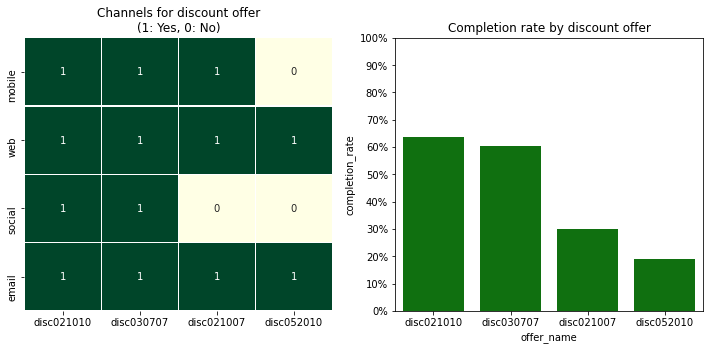

In [137]:
## Discount offers

# Subset dataset
channels = ['mobile', 'web', 'social', 'email']
completion_discount = completion_by_offer.query('offer_type == "discount"')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

# Figure1 - heatmap for binary
sns.heatmap(completion_discount[channels].T, linewidths = 0.30, annot = True, 
            cmap='YlGn', cbar=False, ax=ax1);

# Labels
ax1.set_title('Channels for discount offer\n(1: Yes, 0: No)')
ax1.set_xticklabels(labels=completion_discount['offer_name'], rotation=0)
ax1.set(xlabel='', ylabel='')

# Figure2 - bar
sns.barplot(x='offer_name', y='completion_rate', data=completion_discount, ax=ax2, color='green')

# Labels
ax2.set(title='Completion rate by discount offer')
ax2.set_xticks(ticks=np.arange(len(completion_discount)))
ax2.set_xticklabels(labels=completion_discount['offer_name'], rotation=0)
ax2.set_yticks(ticks=np.arange(0, 1+0.1, 0.1))
ax2.set_yticklabels(labels=['{:.0f}'.format(n*100) + '%' for n in np.arange(0, 1+0.1, 0.1)])

plt.tight_layout(pad=1.2)

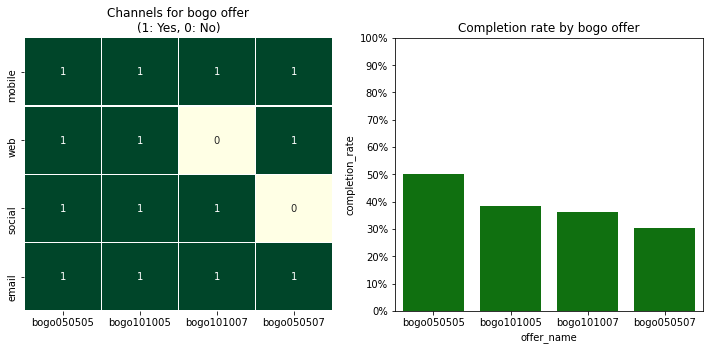

In [138]:
## Discount offers

# Subset dataset
channels = ['mobile', 'web', 'social', 'email']
completion_bogo = completion_by_offer.query('offer_type == "bogo"')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

# Figure1 - heatmap for binary
sns.heatmap(completion_bogo[channels].T, linewidths = 0.30, annot = True, 
            cmap='YlGn', cbar=False, ax=ax1);

# Labels
ax1.set_title('Channels for bogo offer\n(1: Yes, 0: No)')
ax1.set(xlabel='', ylabel='')
ax1.set_xticklabels(labels=completion_bogo['offer_name'], rotation=0)

# Figure2 - bar
sns.barplot(x='offer_name', y='completion_rate', data=completion_bogo, ax=ax2, color='green')

# Labels
ax2.set(title='Completion rate by bogo offer')
ax2.set_xticks(ticks=np.arange(len(completion_bogo)))
ax2.set_xticklabels(labels=completion_bogo['offer_name'], rotation=0)
ax2.set_yticks(ticks=np.arange(0, 1+0.1, 0.1))
ax2.set_yticklabels(labels=['{:.0f}'.format(n*100) + '%' for n in np.arange(0, 1+0.1, 0.1)])

plt.tight_layout(pad=1.2)

### 4c. Offer completion by demographics

There are 5 possible behaviours identified through the funnels and each will be labeled as following.

1. complete
2. inactive : incomplete, no purchase after offer viewed
3. active   : incomplete, but purchased without offer viewed
4. indifferent: incomplete, no purchase no view
5. not received 

For this analysis, label 5 (not received) is not considered.

In [139]:
# Prepare dataset for analysis

# Merge with profile_v1 dataset
completion_demo = pd.merge(transactions_sent, profile, left_on='person', right_on='id', how='left')

# Drop the duplicated id column
completion_demo = completion_demo.drop(columns='id')

# Set the label order 
label_order = list(label_num_to_name.values())[:-1]
completion_demo.label_descr = pd.Categorical(completion_demo.label_descr, categories=label_order)

In [140]:
completion_demo.head()

,person,offer_id,offer received,offer viewed,transaction,offer completed,label,amount,reward,label_descr,gender,age,became_member_on,income
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,576.0,NaN,NaN,576.0,3.0,10.27,2.0,active,M,33.0,2017-04-21,72000.0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,336.0,372.0,NaN,NaN,1.0,NaN,NaN,complete,M,33.0,2017-04-21,72000.0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,168.0,192.0,NaN,NaN,1.0,NaN,NaN,complete,M,33.0,2017-04-21,72000.0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,408.0,456.0,NaN,414.0,3.0,8.57,5.0,active,M,33.0,2017-04-21,72000.0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,504.0,540.0,NaN,528.0,3.0,14.11,2.0,active,M,33.0,2017-04-21,72000.0


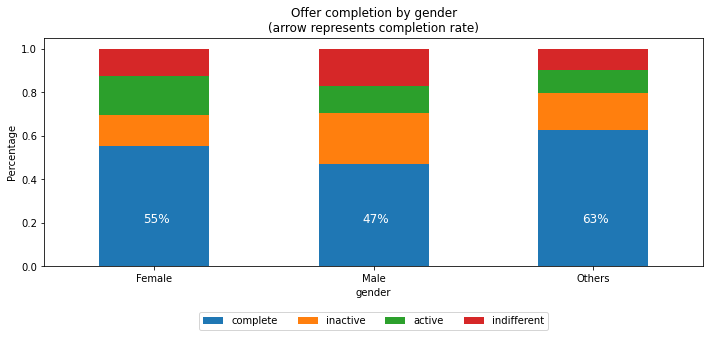

In [141]:
# Pivot completion by gender
completion_gender = completion_demo.groupby(['label_descr', 'gender']).size().unstack()
completion_gender_perc = completion_gender / completion_gender.sum(axis=0)

# Plot 
completion_gender_perc.T.plot(kind='bar', stacked=True, figsize=(10,5));

# Annotation
for i, _type in enumerate(completion_gender.columns):
    compl_rate = completion_gender_perc.loc['complete', _type]    
    plt.text(i-0.05, 0.2, '{:.0f}%'.format(compl_rate * 100), 
             color='#fff', fontsize=12)

plt.title('Offer completion by gender\n(arrow represents completion rate)')
plt.xticks(rotation=0, ticks=np.arange(3), labels=['Female', 'Male', 'Others'])
plt.ylabel('Percentage')

plt.legend(loc=8, ncol=len(completion_gender.index), bbox_to_anchor=(0.50, -0.30))
plt.tight_layout(pad=1.2)
plt.show()

Female customers generally have higher completion rate than male. Male customers are less active to promotional offers - viewing an offere less likely to lead to purchase.

### Completion by age

In [142]:
# Divide each record with age group
bin_edges = np.arange(10, 100+10, 10)
bin_label = [str(n)+ 's' for n in bin_edges[:-1]]
completion_demo['age_group'] = pd.cut(completion_demo.age, bins=bin_edges, labels=bin_label)

# Pivot completion by age
completion_age = completion_demo.groupby(['label_descr', 'age_group']).size().unstack()
completion_age_perc = completion_age / completion_age.sum(axis=0)

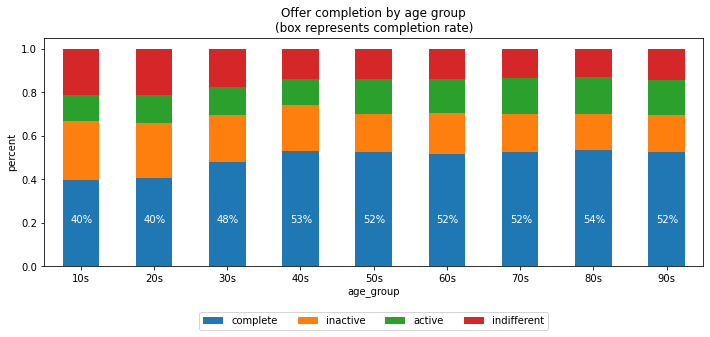

In [143]:
# Plot 
completion_age_perc.T.plot(kind='bar', stacked=True, figsize=(10,5));

# Annotation
for i, val in enumerate(completion_age_perc.columns):
    compl_rt = completion_age_perc[val][0]    
    plt.text(i-0.14, 0.2, '{:.0f}%'.format(compl_rt * 100), 
             color='#fff', fontsize=10)

plt.title('Offer completion by age group\n(box represents completion rate)')
plt.xticks(rotation=0)
plt.ylabel('percent')

plt.legend(loc=8, ncol=len(completion_age_perc.index), bbox_to_anchor=(0.50, -0.30))
plt.tight_layout(pad=1.2)
plt.show()

Completion rate is low (lower than incomplete) for customers below 30s whereas those above 40s have completion rate higher than 50%.

### Completion by income

In [144]:
# Divide each record with income group
bin_edges = np.arange(completion_demo.income.min(), completion_demo.income.max() + 10000, 10000)
bin_label = ['$' + str(int(n))[:-3] + 'k' for n in bin_edges[:-1]]
completion_demo['income_group'] = pd.cut(completion_demo.income, bins=bin_edges, labels=bin_label)

# Pivot completion by income
completion_income = completion_demo.groupby(['label_descr', 'income_group']).size().unstack()
completion_income_perc = completion_income / completion_income.sum(axis=0)

In [145]:
completion_income_perc

income_group,$30k,$40k,$50k,$60k,$70k,$80k,$90k,$100k,$110k
label_descr,,,,,,,,,
complete,0.391871,0.403701,0.518489,0.529297,0.552808,0.596989,0.596785,0.498529,0.518002
inactive,0.278270,0.254662,0.221467,0.207782,0.156536,0.133946,0.135160,0.098529,0.083043
active,0.106566,0.124840,0.115831,0.132151,0.165063,0.183223,0.187684,0.260294,0.245064
indifferent,0.223293,0.216797,0.144213,0.130770,0.125594,0.085843,0.080371,0.142647,0.153891


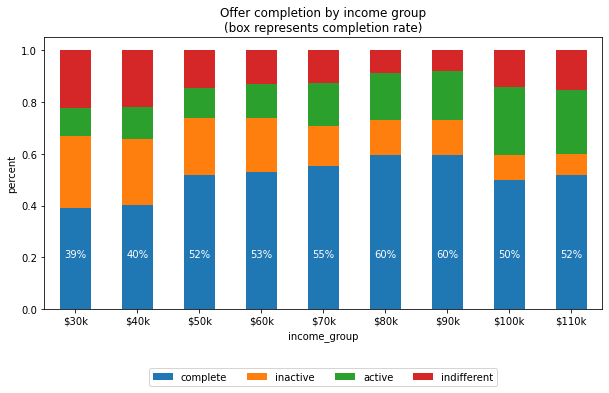

In [146]:
# Plot 
completion_income_perc.T.plot(kind='bar', stacked=True, figsize=(10,5));

# Annotation
for i, val in enumerate(completion_income_perc.columns):
    compl_rt = completion_income_perc[val][0]    
    plt.text(i-.17, 0.2, '{:.0f}%'.format(compl_rt * 100), 
             color='#fff', fontsize=10)

plt.title('Offer completion by income group\n(box represents completion rate)')
plt.xticks(rotation=0)
plt.ylabel('percent')

plt.legend(loc=8, ncol=len(completion_income_perc.index), bbox_to_anchor=(0.50, -0.30))
plt.show()

Completion rate is lower for customers with income less than \\$50k. The higest completion rate is observed in the income group between \\$80k and \\$100k.

---
<a id="feature"></a>
## SECTION5 Feature engineering
Now merge the cleaned dataset to prepare for a classifer model. Load the cleand dataset again to ensure that the correct data is used.

In [5]:
# Load dataset
portfolio = pd.read_csv('data/portfolio_clean.csv')
profile = pd.read_csv('data/profile_clean.csv')
transactions = pd.read_csv('data/transactions_pivoted.csv')

### 5a. Merging the dataset 

In [6]:
df = pd.merge(transactions, profile, left_on='person', right_on='id', how='left')
df.head()

,person,offer_id,offer received,offer viewed,transaction,offer completed,label,amount,reward,gender,age,id,became_member_on,income
0,0009655768c64bdeb2e877511632db8f,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN,NaN,5.0,NaN,NaN,M,33.0,0009655768c64bdeb2e877511632db8f,2017-04-21,72000.0
1,0009655768c64bdeb2e877511632db8f,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,NaN,NaN,NaN,5.0,NaN,NaN,M,33.0,0009655768c64bdeb2e877511632db8f,2017-04-21,72000.0
2,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,576.0,NaN,NaN,576.0,3.0,10.27,2.0,M,33.0,0009655768c64bdeb2e877511632db8f,2017-04-21,72000.0
3,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,336.0,372.0,NaN,NaN,1.0,NaN,NaN,M,33.0,0009655768c64bdeb2e877511632db8f,2017-04-21,72000.0
4,0009655768c64bdeb2e877511632db8f,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,M,33.0,0009655768c64bdeb2e877511632db8f,2017-04-21,72000.0


In [7]:
df = pd.merge(df, portfolio, left_on='offer_id', right_on='id', how='left')
df.head()

,person,offer_id,offer received,offer viewed,transaction,offer completed,label,amount,reward_x,gender,...,income,reward_y,difficulty,duration,offer_type,id_y,web,email,social,mobile
0,0009655768c64bdeb2e877511632db8f,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN,NaN,5.0,NaN,NaN,M,...,72000.0,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0
1,0009655768c64bdeb2e877511632db8f,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,NaN,NaN,NaN,5.0,NaN,NaN,M,...,72000.0,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
2,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,576.0,NaN,NaN,576.0,3.0,10.27,2.0,M,...,72000.0,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1
3,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,336.0,372.0,NaN,NaN,1.0,NaN,NaN,M,...,72000.0,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
4,0009655768c64bdeb2e877511632db8f,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,M,...,72000.0,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 170000 entries, 0 to 169999
Data columns (total 23 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   person            170000 non-null  object 
 1   offer_id          170000 non-null  object 
 2   offer received    63288 non-null   float64
 3   offer viewed      49135 non-null   float64
 4   transaction       0 non-null       float64
 5   offer completed   28996 non-null   float64
 6   label             170000 non-null  float64
 7   amount            28996 non-null   float64
 8   reward_x          28996 non-null   float64
 9   gender            148250 non-null  object 
 10  age               148250 non-null  float64
 11  id_x              148250 non-null  object 
 12  became_member_on  148250 non-null  object 
 13  income            148250 non-null  float64
 14  reward_y          170000 non-null  int64  
 15  difficulty        170000 non-null  int64  
 16  duration          17

### 5b. Clean data

After merging, drop unnecessary columns:
- offer received, offer viewed, transaction, offer completed : **label** can replace
- reward_y, id_x, id_y: duplicated

In [9]:
# Drop unncessary columns

dropcols = ['offer received', 'offer viewed', 'transaction', 'offer completed',
            'reward_y', 'id_x', 'id_y']

df = df.drop(columns=dropcols)
df = df.rename(columns={'reward_x': 'reward'})

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 170000 entries, 0 to 169999
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   person            170000 non-null  object 
 1   offer_id          170000 non-null  object 
 2   label             170000 non-null  float64
 3   amount            28996 non-null   float64
 4   reward            28996 non-null   float64
 5   gender            148250 non-null  object 
 6   age               148250 non-null  float64
 7   became_member_on  148250 non-null  object 
 8   income            148250 non-null  float64
 9   difficulty        170000 non-null  int64  
 10  duration          170000 non-null  int64  
 11  offer_type        170000 non-null  object 
 12  web               170000 non-null  int64  
 13  email             170000 non-null  int64  
 14  social            170000 non-null  int64  
 15  mobile            170000 non-null  int64  
dtypes: float64(5), int64

Further feature cleaning
- **amount** and **reward** are null when there is no transaction: fill the missing values with 0
- demographic information are missing for some persons (21,750, 12.7% of the total data) : drop them as there are not much of data to use for imputation

In [11]:
# Fill missing amount and reweard values with 0 

df['amount'] = df['amount'].fillna(0)
df['reward'] = df['reward'].fillna(0)

In [12]:
# Drop records with missing demo values 

df = df[df['gender'].notnull()]
df.shape

(148250, 16)

In [13]:
df.isnull().sum()

person              0
offer_id            0
label               0
amount              0
reward              0
gender              0
age                 0
became_member_on    0
income              0
difficulty          0
duration            0
offer_type          0
web                 0
email               0
social              0
mobile              0
dtype: int64

#### Continue with future cleaning

**target variable** : `label` 
- Create the subset dataframe excluding **unsent** offer status

**predictors**
- drop **person** column: too specific to use an individual person as a feature
- drop **offer_id** : shares the same information as **offer_type**
- convert **gender** and **offer_type** into dummy variables (avoid reduncy or [dummy variable trap](https://www.geeksforgeeks.org/ml-dummy-variable-trap-in-regression-models/))
- transform **became_member_on** into numeric value: The most recent record is 2018-07-26. Create **recency** variable - suppose that this analysis was performed on '2019-01-01', calculate days difference from this reference date

In [14]:
# Futher processing for predictors
# Drop person, offer_id features

df = df.drop(columns=['person', 'offer_id'])

In [15]:
# Make dummy variables for gender and offer_type  

df = pd.concat([df, pd.get_dummies(df.gender, drop_first=True)], axis=1)
df = pd.concat([df, pd.get_dummies(df.offer_type, drop_first=True)], axis=1)

In [16]:
# Convert into clear feature names

df = df.rename(columns={'M' : 'gender_male', 'O': 'gender_other'})
df = df.drop(columns=['gender', 'offer_type'])

In [17]:
# Compute recency 

def calculate_recency(date):
    
    ref_date = datetime.date(2019,1,1)
    date_obj = datetime.datetime.strptime(date, '%Y-%m-%d').date()
        
    recency = ref_date - date_obj
    recency = int(recency.days)
    
    return recency

df['recency'] = df['became_member_on'].apply(calculate_recency)
df = df.drop(columns='became_member_on')

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148250 entries, 0 to 169999
Data columns (total 16 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   label          148250 non-null  float64
 1   amount         148250 non-null  float64
 2   reward         148250 non-null  float64
 3   age            148250 non-null  float64
 4   income         148250 non-null  float64
 5   difficulty     148250 non-null  int64  
 6   duration       148250 non-null  int64  
 7   web            148250 non-null  int64  
 8   email          148250 non-null  int64  
 9   social         148250 non-null  int64  
 10  mobile         148250 non-null  int64  
 11  gender_male    148250 non-null  uint8  
 12  gender_other   148250 non-null  uint8  
 13  discount       148250 non-null  uint8  
 14  informational  148250 non-null  uint8  
 15  recency        148250 non-null  int64  
dtypes: float64(5), int64(7), uint8(4)
memory usage: 15.3 MB


In [19]:
# Save the final data

df.to_csv('data/starbucks_data_final.csv', index=False)

### 5c. Create train, test set
Normally, train and test sets are randomly split. However, in this project, a different approach will be taken.

Label 5 corresponds to **not received**. In other words, they represent unsent offers and cannot possibly tell customer behaviours. I will set these data records aside, and use it to . This process is not ideal as it reduces train set significantly given a large proportion of the unsent offer data. However, using unsent offers in the training does not make sense anyways.

In [20]:
# Reload the final dataset

df = pd.read_csv('data/starbucks_data_final.csv')

In [21]:
# Divide data for dev_set and out of bag sets

dev_set = df.query('label != 5')
oob_set = df.query('label == 5')
print('Development data size:', dev_set.shape[0])
print('Out of bag data size:', oob_set.shape[0])

X = dev_set.drop(columns='label')
y = dev_set['label']

Development data size: 55222
Out of bag data size: 93028


In [22]:
# Train and test split with data set for development (dev_set) 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
print('X train size:', X_train.shape[0])
print('y train size:', y_train.shape[0])
print('X test size:', X_test.shape[0])
print('y test size:', y_test.shape[0])

X train size: 44177
y train size: 44177
X test size: 11045
y test size: 11045


### 5d. Handle imbalanced label
The completion will be classified into 4 classes. In order to avoid label imbalance issue, invariant metric will be introduced. In case that labels are not balance, the model may end up performing poorly on a minority label better and will product biased classification results.

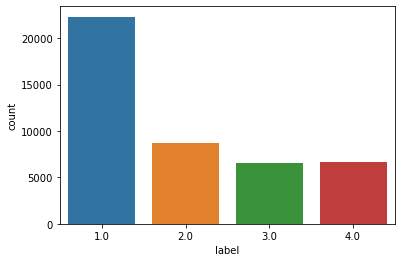

In [23]:
# Plot to see the imbalance issue

sns.countplot(x = y_train);

The labels are highly imbalanced with a lot of Label 1 (completed) existing in the training set. Before modeling, I will create two different train sets with oversampling and undersampling using **imbalanced-learn** Python library.

- Oversampling: 
[Reference](https://machinelearningmastery.com/multi-class-imbalanced-classification/)

By default, the library uses SMOTE (Synthetic Minority Oversampling Technique) that will oversample(synthesizes) minority classes so all labels share the same number of examples as the class with the most examples.

- Undersampling:
[Reference](https://machinelearningmastery.com/undersampling-algorithms-for-imbalanced-classification/)

In [24]:
# Function to apply SMOTE

def oversample_data(X, y, return_results=True):
    oversample = SMOTE()
    X_train, y_train = oversample.fit_resample(X, y)
    # summarize distribution
    counter = Counter(y_train)
    
    for k, v in counter.items():
        per = v / len(y_train) * 100
        print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
    
    if return_results:
        # plot the distribution
        plt.bar(counter.keys(), counter.values())
        plt.show()
    
    return X_train, y_train
    

Class=3, n=22305 (25.000%)
Class=2, n=22305 (25.000%)
Class=1, n=22305 (25.000%)
Class=4, n=22305 (25.000%)


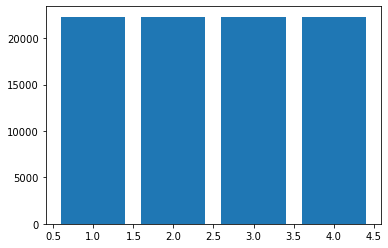

In [25]:
# Oversample training set

X_train_over, y_train_over = oversample_data(X_train, y_train)

In [26]:
def undersample_data(X, y, return_results=True):
        
    # define the undersampling method
    undersample = NearMiss(version=1)
    X_train, y_train = undersample.fit_resample(X, y)
    
    counter = Counter(y_train)
    
    for k, v in counter.items():
        per = v / len(y_train) * 100
        print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
    
    if return_results:
        # plot the distribution
        plt.bar(counter.keys(), counter.values())
        plt.show()
    
    return X_train, y_train


Class=1, n=6500 (25.000%)
Class=2, n=6500 (25.000%)
Class=3, n=6500 (25.000%)
Class=4, n=6500 (25.000%)


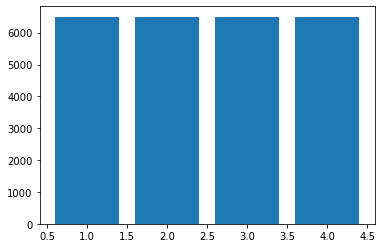

In [27]:
# Undersample training set

X_train_under, y_train_under = undersample_data(X_train, y_train)

---

<a id="model"></a>
## SECTION6 Modeling

I would like to build a classifier model to predict offer completion given a set of variables, such as demogrpahics, offer types, channels, etc.

Each model will have a different classification algorithm and will be fit with three different data sets with
- oversampled labels (_over)
- undersampled labels (_under)

In [28]:
# Function to evaluate training

def scale_predictors(X_train, X_test, returen_s):
    ''' Using the statistics from X_train, 
    standardize the values in the training sets.
    
    INPUT: 
        X_train: X predictors in the train set
        X_test: X predictors in the test set
    
    OUTPUT:
        X_train, X_test: scaled predictors
    
    '''
    
    # Instantiate scaler
    scaler = StandardScaler()
    
    # Fit and tranform X_train 
    X_train_scaled = scaler.fit_transform(X_train) # fitting training set only     
    
    # Transform X_test     
    X_test_scaled = scaler.transform(X_test) 
    
    return X_train_scaled, X_test_scaled
    
    
    
def model_predict(model, X_test):
    ''' Run predictions for a fitted classifer model
    
    INPUT:
        model: a fitted classifer model
        X_test: test features used for prediction
        
    OUTPUT:
        y_pred: the predicted target variable
        
    '''
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    return y_pred


def evaluate_model(y_test, y_pred):
    ''' Show test scores for classification as one go
    by combining accuracy score and classification report.
    
    INPUT: 
        model: the classifier model that fit training sets
        y_test: a true y test values
        y_pred: a predicted y values
        
    OUTPUT:
        None
        
    '''
       
    # Get test scores
    print(f'Accuracy score: {accuracy_score(y_test, y_pred) * 100:.2f}%')
    print(f'Classfication report:\n')
    print(classification_report(y_test, y_pred))
    

### 5a. Scale predictors
Each feature has different units and ranges of values. Scaling will make the model trained more effectively.

In [29]:
# Scale predictors for both train and test set 

X_train_over, X_test_over = scale_predictors(X_train_over, X_test)
X_train_under, X_test_under = scale_predictors(X_train_under, X_test)
print('X train size (oversampled):', X_train_over.shape[0])
print('X train size (oversampled):', X_test_over.shape[0])
print('X test size (undersampled):', X_train_under.shape[0])
print('X test size (undersampled):', X_test_under.shape[0]) # same as X_test_over

X train size (oversampled): 89220
X train size (oversampled): 11045
X test size (undersampled): 26000
X test size (undersampled): 11045


### 5b. model_01 logistic regression

In [30]:
# Fitting the model 
# model_01o : oversampled

model_01o = LogisticRegression(random_state=123, max_iter=1000)
model_01o.fit(X_train_over, y_train_over)

LogisticRegression(max_iter=1000, random_state=123)

In [31]:
# Make predictions on train and test set

ypred_01o_train = model_predict(model_01o, X_train_over)
ypred_01o_test = model_predict(model_01o, X_test_over)

In [32]:
# Evaluate the model performance

evaluate_model(y_train_over, ypred_01o_train)
evaluate_model(y_test, ypred_01o_test)

Accuracy score: 80.29%
Classfication report:

              precision    recall  f1-score   support

         1.0       0.80      0.66      0.73     22305
         2.0       0.94      0.76      0.84     22305
         3.0       0.79      0.87      0.82     22305
         4.0       0.73      0.93      0.82     22305

    accuracy                           0.80     89220
   macro avg       0.82      0.80      0.80     89220
weighted avg       0.82      0.80      0.80     89220

Accuracy score: 72.57%
Classfication report:

              precision    recall  f1-score   support

         1.0       0.86      0.66      0.75      5573
         2.0       0.93      0.82      0.87      2203
         3.0       0.46      0.69      0.56      1606
         4.0       0.59      0.85      0.69      1663

    accuracy                           0.73     11045
   macro avg       0.71      0.76      0.72     11045
weighted avg       0.77      0.73      0.74     11045



In [33]:
# Fitting the model 
# model_01u : undersampled

model_01u = LogisticRegression(random_state=123, max_iter=1000)
model_01u.fit(X_train_under, y_train_under)

LogisticRegression(max_iter=1000, random_state=123)

In [34]:
# Make predictions on train and test set

ypred_01u_train = model_predict(model_01u, X_train_under)
ypred_01u_test = model_predict(model_01u, X_test_under)

In [35]:
# Evaluate the model performance

evaluate_model(y_train_under, ypred_01u_train)
evaluate_model(y_test, ypred_01u_test)

Accuracy score: 78.45%
Classfication report:

              precision    recall  f1-score   support

         1.0       0.69      0.72      0.70      6500
         2.0       0.92      0.82      0.87      6500
         3.0       0.74      0.68      0.71      6500
         4.0       0.81      0.91      0.86      6500

    accuracy                           0.78     26000
   macro avg       0.79      0.78      0.78     26000
weighted avg       0.79      0.78      0.78     26000

Accuracy score: 69.02%
Classfication report:

              precision    recall  f1-score   support

         1.0       0.86      0.57      0.69      5573
         2.0       0.93      0.82      0.87      2203
         3.0       0.48      0.69      0.56      1606
         4.0       0.49      0.91      0.64      1663

    accuracy                           0.69     11045
   macro avg       0.69      0.75      0.69     11045
weighted avg       0.76      0.69      0.70     11045



Not extremely bad score for all metrics for the first model (test accuracy around 73%). However, overfitting exists and there still is a room to improve seeing lower f1-score for label 3 and 4 classification with the test set. Between the two sampling methods, the model with overasmpled dataset produced slightly higher accuracy for both train and test set.

Nevertheless, training accuracy still is around 80%, which suggests that model itself can be improved more. Let's use other machine learning classifiers.

#### Feature importance
When fitting the logistic regression model, features were selected based on availability and relevance. Let's see how the model evaluates the importance of each feature by comparing the coefficients of each feature.

In [92]:
# Get the feature names 
feature_names = X.columns.tolist()

def plot_feature_importances(series, c):
        
    plt.barh(series.index, series.Importance, color=c) 
    plt.axvline(x=0, color='.5')
    plt.xlabel('coefficient')
    plt.ylabel('feature')        
    
    
def feature_importance(model, feature_names, plot_result=True):
    ''' Find the importance of each features by coefficients.
    The highest coefficient corresponds to the most importance feature here.
    
    The computed result will be proportional to the highest coefficient value 
    amont the features. Therefore, the most important feature should return 1.0.    
    
    
    If plot_result=True, horizional barplot will be returned instead of dataframe.
    
    '''
    
    coefs = model.coef_[0]
    coefs_prop = 100.0 * (coefs / coefs.max())
    
    result = pd.DataFrame(index=feature_names, data=coefs_prop)    
    result.columns = ['Importance']
    result = result.sort_values(by='Importance', ascending=False)
    
    if plot_result:
        
        pos_data = result[result.Importance >= 0]
        neg_data = result[result.Importance < 0]
        
        plt.figure(figsize=(10,6))
        plot_feature_importances(pos_data, 'b')
        plot_feature_importances(neg_data, 'r')        
        plt.show()
        
    else:
        return feature_importance
    

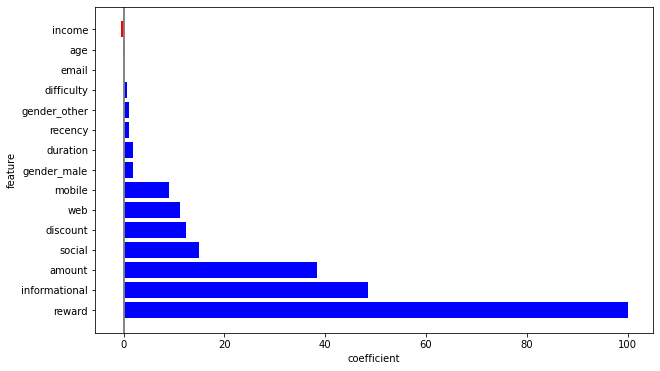

In [93]:
feature_importance(model_01o, feature_names)

The feature importance chart tells that types and channels related to each offer contributes more to predicting completion, rather than demographic features like age or income. The earlier exploratory analysis suggested these demographic factors would play a role no matter how significant. Let's continue with another model and evaluate the feature importance.

### 5c. model_02 decision tree 

In [76]:
# Fitting the model
# model_02o : oversampled

model_02o = DecisionTreeClassifier(max_depth=12)
model_02o.fit(X_train_over, y_train_over)

DecisionTreeClassifier(max_depth=12)

In [77]:
# Make predictions on train and test set

ypred_02o_train = model_predict(model_02o, X_train_over)
ypred_02o_test = model_predict(model_02o, X_test_over)

In [78]:
# Evaluate the model performance

evaluate_model(y_train_over, ypred_02o_train)
evaluate_model(y_test, ypred_02o_test)

Accuracy score: 85.82%
Classfication report:

              precision    recall  f1-score   support

         1.0       0.80      0.84      0.82     22305
         2.0       0.92      0.87      0.89     22305
         3.0       0.89      0.85      0.87     22305
         4.0       0.83      0.88      0.85     22305

    accuracy                           0.86     89220
   macro avg       0.86      0.86      0.86     89220
weighted avg       0.86      0.86      0.86     89220

Accuracy score: 76.13%
Classfication report:

              precision    recall  f1-score   support

         1.0       0.81      0.82      0.81      5573
         2.0       0.89      0.88      0.88      2203
         3.0       0.54      0.51      0.53      1606
         4.0       0.65      0.67      0.66      1663

    accuracy                           0.76     11045
   macro avg       0.72      0.72      0.72     11045
weighted avg       0.76      0.76      0.76     11045



In [79]:
# Fitting the model 
# model_02u : undersampled

model_02u = DecisionTreeClassifier(max_depth=12)
model_02u.fit(X_train_under, y_train_under)

DecisionTreeClassifier(max_depth=12)

In [80]:
# Make predictions on train and test set

ypred_02u_train = model_predict(model_02u, X_train_under)
ypred_02u_test = model_predict(model_02u, X_test_under)

In [81]:
# Evaluate the model performance

evaluate_model(y_train_under, ypred_02u_train)
evaluate_model(y_test, ypred_02u_test)

Accuracy score: 83.56%
Classfication report:

              precision    recall  f1-score   support

         1.0       0.73      0.83      0.78      6500
         2.0       0.91      0.91      0.91      6500
         3.0       0.82      0.70      0.76      6500
         4.0       0.89      0.90      0.90      6500

    accuracy                           0.84     26000
   macro avg       0.84      0.84      0.84     26000
weighted avg       0.84      0.84      0.84     26000

Accuracy score: 66.34%
Classfication report:

              precision    recall  f1-score   support

         1.0       0.83      0.55      0.66      5573
         2.0       0.90      0.84      0.87      2203
         3.0       0.43      0.63      0.51      1606
         4.0       0.48      0.85      0.61      1663

    accuracy                           0.66     11045
   macro avg       0.66      0.72      0.66     11045
weighted avg       0.73      0.66      0.67     11045



With the decision tree model, test accuracy increased from 73% to 76% only when oversampling technique is applied. Undersampling technique produced zero division error for precision, implying zero instances of positive prediction for label 2.

#### Feature importance
Sklearn's decision tree API has a built-in feature importance feature.

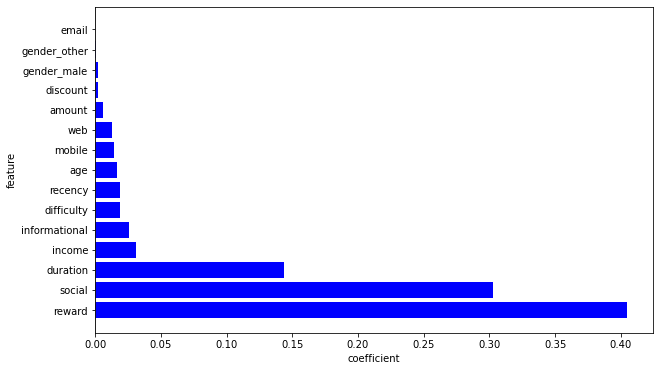

In [94]:
# The built-in method produces feature importances that are > 0

feature_result = pd.DataFrame(index=feature_names, data=model_02o.feature_importances_)    
feature_result.columns = ['Importance']
feature_result = feature_result.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
plot_feature_importances(feature_result, c='b')
plt.show()

In the decision tree, demographic factors like income and age contributed more to predicting the offer completion. **reward**, **social** and **duration**, however, are seen more important predictors.

### 5d. Model_03 random forecast classifier

In [95]:
# Fitting the model
# model_03o : oversampled

model_03o = RandomForestClassifier(max_depth=12)
model_03o.fit(X_train_over, y_train_over)

RandomForestClassifier(max_depth=12)

In [96]:
# Make predictions on train and test set

ypred_03o_train = model_predict(model_03o, X_train_over)
ypred_03o_test = model_predict(model_03o, X_test_over)

In [97]:
# Evaluate the model performance

evaluate_model(y_train_over, ypred_03o_train)
evaluate_model(y_test, ypred_03o_test)

Accuracy score: 86.02%
Classfication report:

              precision    recall  f1-score   support

         1.0       0.82      0.81      0.81     22305
         2.0       0.94      0.87      0.90     22305
         3.0       0.86      0.86      0.86     22305
         4.0       0.83      0.90      0.86     22305

    accuracy                           0.86     89220
   macro avg       0.86      0.86      0.86     89220
weighted avg       0.86      0.86      0.86     89220

Accuracy score: 77.41%
Classfication report:

              precision    recall  f1-score   support

         1.0       0.83      0.80      0.82      5573
         2.0       0.92      0.86      0.89      2203
         3.0       0.55      0.59      0.57      1606
         4.0       0.66      0.74      0.70      1663

    accuracy                           0.77     11045
   macro avg       0.74      0.75      0.74     11045
weighted avg       0.78      0.77      0.78     11045



In [98]:
# Fitting the model 
# model_03u : undersampled

model_03u = DecisionTreeClassifier(max_depth=12)
model_03u.fit(X_train_under, y_train_under)

DecisionTreeClassifier(max_depth=12)

In [99]:
# Make predictions on train and test set

ypred_03u_train = model_predict(model_03u, X_train_under)
ypred_03u_test = model_predict(model_03u, X_test_under)

In [100]:
# Evaluate the model performance

evaluate_model(y_train_under, ypred_03u_train)
evaluate_model(y_test, ypred_03u_test)

Accuracy score: 83.57%
Classfication report:

              precision    recall  f1-score   support

         1.0       0.73      0.83      0.78      6500
         2.0       0.91      0.91      0.91      6500
         3.0       0.82      0.70      0.76      6500
         4.0       0.89      0.90      0.90      6500

    accuracy                           0.84     26000
   macro avg       0.84      0.84      0.84     26000
weighted avg       0.84      0.84      0.84     26000

Accuracy score: 66.36%
Classfication report:

              precision    recall  f1-score   support

         1.0       0.82      0.55      0.66      5573
         2.0       0.90      0.85      0.87      2203
         3.0       0.43      0.62      0.51      1606
         4.0       0.48      0.85      0.62      1663

    accuracy                           0.66     11045
   macro avg       0.66      0.72      0.66     11045
weighted avg       0.73      0.66      0.67     11045



The random forest model produced slighly better test accuracy (77%) with oversampling technique than logistic regression (73%) and (76%).

#### Feature importance

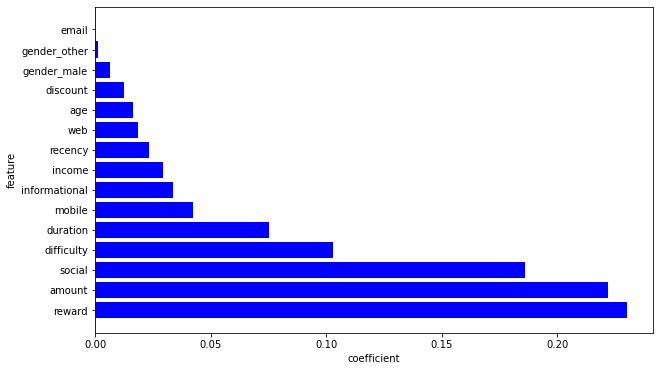

In [101]:
feature_result = pd.DataFrame(index=feature_names, data=model_03o.feature_importances_)    
feature_result.columns = ['Importance']
feature_result = feature_result.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
plot_feature_importances(feature_result, c='b')
plt.show()

reward, amount, social, difficulty and duration plays an important role for prediction when the random forest model is used. Offer type and channel are deemed more important than demographic factors just as logistic regression model told.

### 5e. Model_04 gradient boost classifier

In [102]:
# Fitting the model
# model_04o : oversampled

model_04o = GradientBoostingClassifier()
model_04o.fit(X_train_over, y_train_over)

GradientBoostingClassifier()

In [103]:
# Make predictions on train and test set

ypred_04o_train = model_predict(model_04o, X_train_over)
ypred_04o_test = model_predict(model_04o, X_test_over)

In [104]:
# Evaluate the model performance

evaluate_model(y_train_over, ypred_04o_train)
evaluate_model(y_test, ypred_04o_test)

Accuracy score: 84.36%
Classfication report:

              precision    recall  f1-score   support

         1.0       0.81      0.79      0.80     22305
         2.0       0.93      0.84      0.88     22305
         3.0       0.85      0.86      0.85     22305
         4.0       0.80      0.88      0.84     22305

    accuracy                           0.84     89220
   macro avg       0.85      0.84      0.84     89220
weighted avg       0.85      0.84      0.84     89220

Accuracy score: 76.70%
Classfication report:

              precision    recall  f1-score   support

         1.0       0.83      0.79      0.81      5573
         2.0       0.92      0.86      0.89      2203
         3.0       0.53      0.60      0.56      1606
         4.0       0.65      0.74      0.69      1663

    accuracy                           0.77     11045
   macro avg       0.73      0.75      0.74     11045
weighted avg       0.78      0.77      0.77     11045



In [105]:
# Fitting the model 
# model_04u : undersampled

model_04u = GradientBoostingClassifier()
model_04u.fit(X_train_under, y_train_under)

GradientBoostingClassifier()

In [106]:
# Make predictions on train and test set

ypred_04u_train = model_predict(model_04u, X_train_under)
ypred_04u_test = model_predict(model_04u, X_test_under)

In [107]:
# Evaluate the model performance

evaluate_model(y_train_under, ypred_04u_train)
evaluate_model(y_test, ypred_04u_test)

Accuracy score: 80.29%
Classfication report:

              precision    recall  f1-score   support

         1.0       0.71      0.73      0.72      6500
         2.0       0.91      0.85      0.88      6500
         3.0       0.75      0.72      0.74      6500
         4.0       0.84      0.90      0.87      6500

    accuracy                           0.80     26000
   macro avg       0.80      0.80      0.80     26000
weighted avg       0.80      0.80      0.80     26000

Accuracy score: 68.06%
Classfication report:

              precision    recall  f1-score   support

         1.0       0.86      0.54      0.66      5573
         2.0       0.93      0.85      0.89      2203
         3.0       0.44      0.72      0.54      1606
         4.0       0.51      0.89      0.65      1663

    accuracy                           0.68     11045
   macro avg       0.68      0.75      0.69     11045
weighted avg       0.76      0.68      0.69     11045



Gradient boost classifier performed on par with random forecast (77%) with oversampling method. There still is a room for the model to improve given the training accuracy of ~85%. Let's train with the final classifier, xgboost.

### 5f. Model_05 gradient boost classifier

In [108]:
# Fitting the model
# model_05o : oversampled

model_05o = XGBClassifier(max_depth=12)
model_05o.fit(X_train_over, y_train_over)

/Users/jsuk/opt/anaconda3/envs/dsenv/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:50:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=12, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [109]:
# Make predictions on train and test set

ypred_05o_train = model_predict(model_05o, X_train_over)
ypred_05o_test = model_predict(model_05o, X_test_over)

In [110]:
# Evaluate the model performance

evaluate_model(y_train_over, ypred_05o_train)
evaluate_model(y_test, ypred_05o_test)

Accuracy score: 98.93%
Classfication report:

              precision    recall  f1-score   support

         1.0       0.97      0.99      0.98     22305
         2.0       1.00      1.00      1.00     22305
         3.0       1.00      0.98      0.99     22305
         4.0       0.99      0.99      0.99     22305

    accuracy                           0.99     89220
   macro avg       0.99      0.99      0.99     89220
weighted avg       0.99      0.99      0.99     89220

Accuracy score: 77.19%
Classfication report:

              precision    recall  f1-score   support

         1.0       0.79      0.86      0.83      5573
         2.0       0.89      0.88      0.88      2203
         3.0       0.57      0.44      0.50      1606
         4.0       0.69      0.64      0.66      1663

    accuracy                           0.77     11045
   macro avg       0.73      0.71      0.72     11045
weighted avg       0.76      0.77      0.77     11045



In [111]:
# Fitting the model 
# model_05u : undersampled

model_05u = GradientBoostingClassifier()
model_05u.fit(X_train_under, y_train_under)

GradientBoostingClassifier()

In [112]:
# Make predictions on train and test set

ypred_05u_train = model_predict(model_05u, X_train_under)
ypred_05u_test = model_predict(model_05u, X_test_under)

In [113]:
# Evaluate the model performance

evaluate_model(y_train_under, ypred_05u_train)
evaluate_model(y_test, ypred_05u_test)

Accuracy score: 80.29%
Classfication report:

              precision    recall  f1-score   support

         1.0       0.71      0.73      0.72      6500
         2.0       0.91      0.85      0.88      6500
         3.0       0.75      0.72      0.74      6500
         4.0       0.84      0.90      0.87      6500

    accuracy                           0.80     26000
   macro avg       0.80      0.80      0.80     26000
weighted avg       0.80      0.80      0.80     26000

Accuracy score: 68.07%
Classfication report:

              precision    recall  f1-score   support

         1.0       0.86      0.54      0.66      5573
         2.0       0.93      0.85      0.89      2203
         3.0       0.44      0.72      0.54      1606
         4.0       0.51      0.89      0.65      1663

    accuracy                           0.68     11045
   macro avg       0.68      0.75      0.69     11045
weighted avg       0.76      0.68      0.69     11045



XGBoost classifier clearly overfits given the large difference in accuracy between training (99%) and test set (77%). XGboost also clearly performs better with oversampled dataset.

---
<a id="final"></a>
## SECTION 7 Build the final model

During the initial modeling phase, three machine learning classifier were used: logistic regression, decision tree, random forecast, graident boost and XGboost. The test results are summarized as following:

|               Model               	| Logistic <br>Regression 	| Decision <br>Tree 	| Random <br>Forecast 	| Gradient <br>Boosting 	| XGboost 	|
|:---------------------------------:	|:-----------------------:	|:-----------------:	|:-------------------:	|:---------------------:	|:-------:	|
| Train accuracy<br> - oversampled  	|           81%           	|        86%        	|         86%         	|          85%          	|   99%   	|
| Test accuracy<br> - oversampled   	|           73%           	|        76%        	|       **77%**       	|        **77%**        	| **77%** 	|
| Train accuracy<br> - undersampled 	|           78%           	|        84%        	|         84%         	|          80%          	|   80%   	|
| Test accuracy<br> - undersampled  	|           69%           	|        67%        	|         67%         	|          68%          	|   68%   	|




Random forest, Gradient boost and XGboost share the similar test accuracy. However, random forest will be used due to : 
- less computation than the other two
- XGboost overfits significantly

Also, oversampling method will be adopted as it performed better than undersampling for almost all classifiers.

### 7a. Functions to faciliate modeling

In [153]:
# Function to load the data for modeling

def load_data_for_modeling():
    
    # Load the final dataset
    df = pd.read_csv('data/starbucks_data_final.csv')
    
    # Create X, y for training set
    dev_set = df.query('label != 5')
    X = dev_set.drop(columns='label')
    y = dev_set['label']
    
    return X, y 

In [158]:
# Functions to preprocess data

def oversample_data(X, y, return_results=True):
    oversample = SMOTE()
    X_train, y_train = oversample.fit_resample(X, y)
    # summarize distribution
    counter = Counter(y_train)
    
    for k, v in counter.items():
        per = v / len(y_train) * 100
        print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
    
    if return_results:
        # plot the distribution
        plt.bar(counter.keys(), counter.values())
        plt.show()
    
    return X_train, y_train
    

def scale_predictors(X_train, X_test):
    ''' Using the statistics from X_train, 
    standardize the values in the training sets.
    
    This time the scaler used for the final model
    will be saved for the future use.
    
    INPUT: 
        X_train: X predictors in the train set
        X_test: X predictors in the test set
    
    OUTPUT:
        X_train, X_test: scaled predictors
    
    '''
    
    # Instantiate scaler
    scaler = StandardScaler()
    
    # Fit and tranform X_train 
    X_train_scaled = scaler.fit_transform(X_train) # fitting training set only     
    
    # Transform X_test     
    X_test_scaled = scaler.transform(X_test) 
    
    # Save the scaler    
    # Date of build for the model name
    date_built = datetime.date.today()
    date_built = datetime.datetime.strftime(date_built, format='%Y-%m-%d').replace('-', '')
    
    with open(f'models/final_model_{date_built}_scaler', 'wb') as scaler_pkl:
        pickle.dump(scaler, scaler_pkl)
        print(f'Scaler stored at the path: <models/final_model_{date_built}_scaler>')    
    
    return X_train_scaled, X_test_scaled


def preprocess_data(X, y):
    # Set predictors and label 
    print('Preprocessing data...')
    
    # Split train and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
    
    # Oversample
    print('Oversampling data...')
    X_train, y_train = oversample_data(X_train, y_train)
    
    # Standardize predictors
    X_train, X_test = scale_predictors(X_train, X_test)
    
    return X_train, X_test, y_train, y_test


In [155]:
# Function to build model

def build_final_model(model, X, y, param_grid=None, cv=5, scoring='accuracy', verbose=1):
    ''' Fit a model given by its name. Make a prediction on the train set
    The function requires training and test sets (scaled predictor X) and stored as global variables.
    
    INPUT:
        model_name: a classification algorithm (abbreviated)
        param_grid: A dictionary of hyperparameters. If None, skip parameter tuning.
        random_search: 
            If True, perform random grid search. 
            If False, perform grid search to find best hyperparameters (may take longer time to train)
    
    OUTPUT:
        fitted model
    '''

    # Extract preprocessed data 
    X_train, X_test, y_train, y_test = preprocess_data(X, y)

    
    # Save preprocessed train / test set
    cache = {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test    
    }
            
    # Skip parameter tuning
    if param_grid == None:
        print('Training without parameter tuning')
        final_model = model.fit(X_train, y_train)        
        print('Training has been completed.')

    # Train the best estimator with parameter tuning                                  
    else:
        print('Training with parameter tuning. This process may take time upto several minutes.')
        gridCV = GridSearchCV(model, param_grid=param_grid, cv=cv, scoring=scoring, verbose=verbose)
        gridCV.fit(X_train, y_train) 
        print('Training has been completed with the best hyperparameters found.', gridCV.best_params_)                                
        final_model = gridCV.best_estimator_
    
    
    return final_model, cache

In [156]:
# Functions for model evaluation
    
def model_predict(model, X_test):
    ''' Run predictions for a fitted classifer model
    
    INPUT:
        model: a fitted classifer model
        X_test: test features used for prediction
        
    OUTPUT:
        y_pred: the predicted target variable
        
    '''
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    return y_pred


def evaluate_model(y_test, y_pred):
    ''' Show test scores for classification as one go
    by combining accuracy score and classification report.
    
    INPUT: 
        model: the classifier model that fit training sets
        y_test: a true y test values
        y_pred: a predicted y values
        
    OUTPUT:
        None
        
    '''
       
    # Get test scores
    print(f'Accuracy score: {accuracy_score(y_test, y_pred) * 100:.2f}%')
    print(f'Classfication report:\n')
    print(classification_report(y_test, y_pred))
    

### 7b. Parameter tuning 
Grid search may take lots of time. Therefore run random grid search instead. Range of hyperparameters replicate the workflow from the reference following [the link](https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74).

Nonetheless, parameter tuning still takes time. Therefore, in this section, the actual codes were commented out and the tuned best hyperparameters were presented. In order to run the grid search again, uncomment the below code. The below training is made compact with less iterlation and cross validation, but still takes up to 30 minutes (~2 minutes for run of 15 fits).

Preprocessing data...
Oversampling data...
Class=3, n=22305 (25.000%)
Class=2, n=22305 (25.000%)
Class=1, n=22305 (25.000%)
Class=4, n=22305 (25.000%)


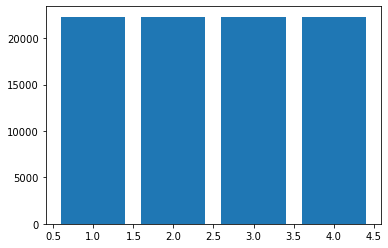

In [128]:
# # Load the dataset
# X, y = load_data_for_modeling()
# X_train, X_test, y_train, y_test = preprocess_data(X, y)

# # Instantiate the final model - random forest
# model = RandomForestClassifier()

In [133]:
# # Uncomment the below code to run the grid search again
# # below training takes up to 30 minutes (~2 minutes for run of 15 fits)

# # Set hyperparameters

# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 5)]

# # Number of features to consider at every split
# max_features = ['auto', 'sqrt']

# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)

# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]

# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]

# # Method of selecting samples for training each tree
# bootstrap = [True, False]

# # Create the random grid
# param_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}


# # Randomized grid search

# randGridCV = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=5, cv=3, scoring='accuracy', verbose=3)
# randGridCV.fit(X_train, y_train)
# print('Best params:', randGridCV.best_params_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV 1/3] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=0.727 total time=   6.5s
[CV 2/3] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=0.872 total time=   6.5s
[CV 3/3] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=0.868 total time=   6.1s
[CV 1/3] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1100;, score=0.728 total time=  47.7s
[CV 2/3] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1100;, score=0.900 total time=  52.8s
[CV 3/3] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1100;, score=0.902 total time=  53.2s
[CV 1/3] END boo

In [142]:
# # Mean test accuracy for each iternation

# randGridCV.cv_results_['mean_test_score']

array([0.8224165 , 0.84333109, 0.84460883, 0.84634611, 0.8460659 ])

The random grid search produced the combination of best hyperparameters as below:

    Best params: {'n_estimators': 1550, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 60, 'bootstrap': False}

Preprocessing data...
Oversampling data...
Class=3, n=22305 (25.000%)
Class=2, n=22305 (25.000%)
Class=1, n=22305 (25.000%)
Class=4, n=22305 (25.000%)


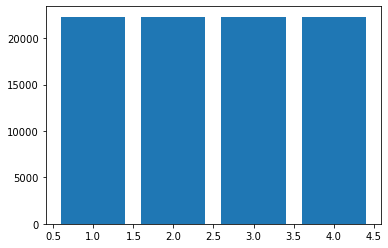

Training without parameter tuning
Training has been completed.


In [136]:
# Build the model 
# with the best combination of hyperparameters

# Instantiate the final model - random forest
model = RandomForestClassifier(n_estimators=1550, min_samples_split=2, min_samples_leaf=2, 
                               max_features='sqrt', max_depth=60, bootstrap=False)

# Reload the dataset
X, y = load_data_for_modeling()

# Build models
final_model, cache = build_final_model(model, X, y, param_grid=None)

In [137]:
# Make a prediction on train and test set

y_pred_train = model_predict(final_model, cache['X_train'])
y_pred_test = model_predict(final_model, cache['X_test'])

In [138]:
# Evaluate the model performance

evaluate_model(cache['y_train'], y_pred_train)
evaluate_model(cache['y_test'], y_pred_test)

Accuracy score: 99.57%
Classfication report:

              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00     22305
         2.0       0.99      1.00      0.99     22305
         3.0       1.00      1.00      1.00     22305
         4.0       1.00      0.99      0.99     22305

    accuracy                           1.00     89220
   macro avg       1.00      1.00      1.00     89220
weighted avg       1.00      1.00      1.00     89220

Accuracy score: 76.99%
Classfication report:

              precision    recall  f1-score   support

         1.0       0.80      0.85      0.82      5573
         2.0       0.89      0.88      0.89      2203
         3.0       0.56      0.47      0.51      1606
         4.0       0.68      0.65      0.66      1663

    accuracy                           0.77     11045
   macro avg       0.73      0.71      0.72     11045
weighted avg       0.76      0.77      0.77     11045



The parameter tuning did not improve the model performance given that the test accuracy stays similar, while the overfitting got worse. Classification for label 3 and 4 still performs poorly on the test set.

The earlier random forest with default set up had a test accuracy of 77% and it only had a change in max_depth set to 12. I will try training the model with a set of light-weight hyperparameters (less computation), searched through grid search.

### 7c. Build the final model

Preprocessing data...
Oversampling data...
Class=3, n=22305 (25.000%)
Class=2, n=22305 (25.000%)
Class=1, n=22305 (25.000%)
Class=4, n=22305 (25.000%)


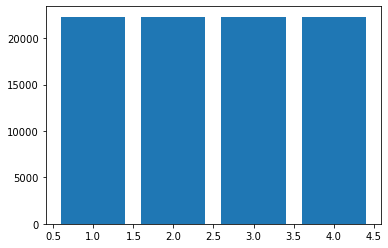

Scaler stored at the path: <models/final_model_20220223_scaler>
Training with parameter tuning. This process may take time upto several minutes.
Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END .......max_depth=2, n_estimators=5;, score=0.672 total time=   0.1s
[CV 2/5] END .......max_depth=2, n_estimators=5;, score=0.685 total time=   0.1s
[CV 3/5] END .......max_depth=2, n_estimators=5;, score=0.721 total time=   0.1s
[CV 4/5] END .......max_depth=2, n_estimators=5;, score=0.680 total time=   0.1s
[CV 5/5] END .......max_depth=2, n_estimators=5;, score=0.771 total time=   0.1s
[CV 1/5] END ......max_depth=2, n_estimators=10;, score=0.625 total time=   0.2s
[CV 2/5] END ......max_depth=2, n_estimators=10;, score=0.768 total time=   0.2s
[CV 3/5] END ......max_depth=2, n_estimators=10;, score=0.754 total time=   0.2s
[CV 4/5] END ......max_depth=2, n_estimators=10;, score=0.805 total time=   0.2s
[CV 5/5] END ......max_depth=2, n_estimators=10;, score=0.703 to

In [159]:
# Rebuild the final model
 
# Instantiate the final model - random forest
model = RandomForestClassifier()

# Reload the dataset
X, y = load_data_for_modeling()

# Set params
param_grid = {
    'max_depth': [2, 5, 10, 15, 20, 25],
    'n_estimators': [5, 10, 50, 100]
}

# Build models
final_model, cache = build_final_model(model, X, y, param_grid=param_grid, verbose=3)

In [160]:
# Make a prediction on train and test set

y_pred_train = model_predict(final_model, cache['X_train'])
y_pred_test = model_predict(final_model, cache['X_test'])

In [161]:
# Evaluate the model performance

evaluate_model(cache['y_train'], y_pred_train)
evaluate_model(cache['y_test'], y_pred_test)

Accuracy score: 99.63%
Classfication report:

              precision    recall  f1-score   support

         1.0       0.99      1.00      0.99     22305
         2.0       1.00      1.00      1.00     22305
         3.0       1.00      0.99      0.99     22305
         4.0       1.00      1.00      1.00     22305

    accuracy                           1.00     89220
   macro avg       1.00      1.00      1.00     89220
weighted avg       1.00      1.00      1.00     89220

Accuracy score: 77.04%
Classfication report:

              precision    recall  f1-score   support

         1.0       0.80      0.84      0.82      5573
         2.0       0.89      0.88      0.89      2203
         3.0       0.56      0.49      0.52      1606
         4.0       0.68      0.65      0.67      1663

    accuracy                           0.77     11045
   macro avg       0.73      0.72      0.72     11045
weighted avg       0.77      0.77      0.77     11045



The final model was trained with a new set of light-weight hyperwparameters. The model fits perfectly on the training set so the model complexity is fine. However, the accuracy on the out of bag data stays 77% - no noticeable improvement when compared with the earlier trainings.

However, what is encouraging is the model predicts label 1.0 and 2.0 quite well considering F1-score higher than 80%. In other words, this classification model would work fine to tell if a potential customer will complete an offer or not, which is the original objective of this project. The limitation is when conducting a granular analysis for incomplete offers. For example, the model may not so precise in telling if customers actually viewed an offer or made a purchase when they didn't activate offers. 

1. complete
2. inactive : incomplete, no purchase after offer viewed
3. active : incomplete, but purchased without offer viewed
4. indifferent: incomplete, no purchase no view

Recall that we haven't used a lots data with unsent offers (93,028 records, vs 55,222 used for the training). Therefore, I suggest that we make predictions on these out of bag data for the next round of offer distributions. Then, a new model could be built with more data records, which might help improve the model performance to more granular level and overfitting issues.

### 7d. Store the final model

In [162]:
# Date of build for the model name

date_built = datetime.date.today()
date_built = datetime.datetime.strftime(date_built, format='%Y-%m-%d').replace('-', '')
print(date_built)

20220223


In [163]:
# Save the final model and train/set set
with open(f'models/final_model_{date_built}', 'wb') as model_pkl:
    pickle.dump(final_model, model_pkl)
    
# Save the final model and train/set set
with open(f'models/final_model_{date_built}_cache', 'wb') as data_pkl:
    pickle.dump(cache, data_pkl)

---
<a id="conclude"></a>
## SECTION 8 Conclusion

To this point, we performed exploratory analysis on individual and trained machine learning classification models. We aimed to find how customers have interacted with differnt offers and finally to predict if offers will lead to completion given a combination of offer types, distributed channels and customer demographics. 

### Insights on offer completion 

#### Offers

Offers were grouped into three categories: bogo, discount and informational. bogo and discount are transactional following the below funnel and offers are considered completion if customers were activate at all stages : 
   
   > offer received -> offer viewed -> purchased -> offer completed

- Of those offers sent, 47% were copmleted indicating that customers viewed offers and made purchases (bogo / disount) or were made aware of offers (informational).
- Amongst the three offer categories, discount offers are the most difficult to redeem (on average 11.75) but have the longest duration allowing customers to be interacted and influenced the most.
- Two transactional offers marked above 60% completion rate and they both fall into discount category. Although these two offers are more difficult to redeem (and less rewards given), they have higher duration and wider distribution across all existing channels so customers had more chances to interact and be influenced.
        
In the meantime, informational offers are considered compelted when customers received and viewed offers (as they do not lead to transactions).
    
- The two informational offers named as **info000003** and **info000004** recorded high completion rate above 60%. Especially, **info000003** showed the highest completion rate (around 90%) despite a slightly shorter duration than the other. It was found that this different may come from communication channels: other than email and mobile, **info000003** distributed on social media as opposed web that **info000004** used.

#### Channels
- Regardless of offer type, email is always used  
- It is more likely to increase the completion when more channels are used
- Across all offer types, using social media led to more completion

#### Demographics

- Female customers have slighly higher completion rate than male customers (53% vs 45%).
- Offer completion rate is lower than 50% for age groups below 50.
- Income groups bewteen 80k and 100k have the highest completion rate (60%). It marked at least 40% completion rate across all income groups.



### Model results


There are 5 possible behaviours identified through the funnels and each will be labeled as following.

1. complete
2. inactive : incomplete, no purchase after offer viewed
3. active   : incomplete, but purchased without offer viewed
4. indifferent: incomplete, no purchase no view
5. not received 

For this analysis, label 5 (not received) is not considered as it does show describe customer behaviours on completion at all.


The final model used random forest classifier, and was built using grid search to find the best combination of hyperparameters.

The training accuracy reached 99% whereas the test accuracy stayed at 77%. The near perfect train accuracy score tells that the model complexity is enough. However, the model is not ideally generalized when predicting out of bag data. 

The model, however, predicts the completion fairly well. However, it does not sufficiently provide more granular analysis on incomplete offers - whether customers actually viewed an offer / made a purchase when offers were not activated. 

Given that the original dataset contains lots of unsent offers, I suggest that we re-utilize these out of bag data - by sending across offers to those customers who likely complete the offers, and gain more insights. The new set of insights will then be trained with another round modeling using a similar workflow presented in this notebook.

Pratically speaking, the costs of offer distribution might not be too significant when leveraging the existing digital medium (social, web, email and mobile).

### Handling unsent offers 

63% of them are labeled unsent possibly because the previous business decisions identified that some offers would not match customers with certain characterstics, resources(time, costs, etc.) were limited or just by chance.

Therefore, in this conclusion section, we would also like to apply our classifier model to those offers unsent and find opportunities for any future promotional activites.

In [148]:
# Reload the final dataset

df = pd.read_csv('data/starbucks_data_final.csv')

# Get the out of bag data (offer unsent)
oob_set = df.query('label == 5')
print('Out of bag data size:', oob_set.shape[0])

X = oob_set.drop(columns='label')
y = oob_set['label']

Out of bag data size: 93028


In [149]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93028 entries, 0 to 148248
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   amount         93028 non-null  float64
 1   reward         93028 non-null  float64
 2   age            93028 non-null  float64
 3   income         93028 non-null  float64
 4   difficulty     93028 non-null  int64  
 5   duration       93028 non-null  int64  
 6   web            93028 non-null  int64  
 7   email          93028 non-null  int64  
 8   social         93028 non-null  int64  
 9   mobile         93028 non-null  int64  
 10  gender_male    93028 non-null  int64  
 11  gender_other   93028 non-null  int64  
 12  discount       93028 non-null  int64  
 13  informational  93028 non-null  int64  
 14  recency        93028 non-null  int64  
dtypes: float64(4), int64(11)
memory usage: 11.4 MB


The out of bag data do not need the entire preprocessing methods used for modeling. For example, splitting train/test set or oversampling is not ncessary. Rescaling will be helpful to standardize ranges and units of values.

In [170]:
# Load scaler

with open('models/final_model_20220223_scaler', 'rb') as scaler_pkl:
    scaler = pickle.load(scaler_pkl)
    
# Load model

with open('models/final_model_20220223', 'rb') as model_pkl:
    model = pickle.load(model_pkl)    

In [171]:
# Scale the out of bag predictors

X_scaled = scaler.transform(X)

In [189]:
# Make predictions for offer completion

predictions = model.predict(X_scaled)
print('Number of predicted labels:', len(predictions))
print('Counts:', Counter(predictions))

Number of predicted labels: 55222
Counts: Counter({1.0: 28265, 2.0: 10930, 4.0: 8230, 3.0: 7797})


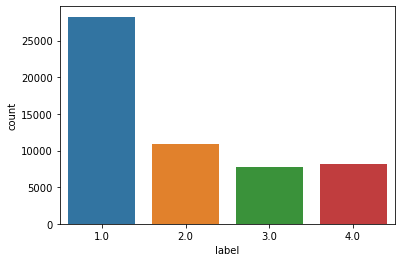

In [190]:
# Plot the predicted labels

sns.countplot(x=predictions)
plt.xlabel('label')
plt.show()

Recall label description:

1. complete
2. inactive : incomplete, no purchase after offer viewed
3. active : incomplete, but purchased without offer viewed
4. indifferent: incomplete, no purchase no view

Over 28265 out of 55222 (51%) unsent offers are likely to be completed (F1-score for the final model : 82%). This gives us an opportunity to drive more offer completions leading to the increase in purchase or informational promotion. Also, the data gather through the future distribution would be used to improve the model performance.

---

<a id="bottom"></a>
Thank you for reading. This is the end of this notebook. <br> Click [here](#top) to move up to the beginning.